# Предисловие

Некоторые замечание по данной тетрадке:

1) Тетрадка запускалась на платформе Kaggle ввиду легкого и беспрерывного доступа к ГПУ

2) Тетрадку нужно запускать с ГПУ, оно используется обильно

3) Все пути прописаны под Kaggle и файлы таким образом придётся подгружать вручную, если использовать, например, Colab

4) Я не использовал в большинстве местах такие методы нормализации как лемматизация и др, так как во многом это портило мои результаты и я терял информацию, в частности лемматизация сломала бы многие именованные сущности

5) Я не трогал также часто знаки пунктуации, поскольку это поломало бы многие кодовые названия, а они тогда бы не попали в единые кластеры

6) Визуализацию кластеров на графики можно закомментить, если желаете сэкономить время

7) Я привел несколько методов в конце тетрадки для сравнения

# Импортирую нужные библиотеки

In [1]:
!pip install --upgrade pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.7 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install navec slovnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.2 MB/s eta 0:00:00


In [3]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
!wget https://storage.yandexcloud.net/natasha-slovnet/packs/slovnet_ner_news_v1.tar

--2023-07-16 20:34:03--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar’

navec_news_v1_1B_25 100%[===================>]  25.40M  9.29MB/s    in 2.7s    

2023-07-16 20:34:06 (9.29 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar’ saved [26634240/26634240]

--2023-07-16 20:34:07--  https://storage.yandexcloud.net/natasha-slovnet/packs/slovnet_ner_news_v1.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2385920 (2.3M) [applica

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
import json
from collections import Counter
from wordcloud import WordCloud

from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm

from navec import Navec
from slovnet import NER

from spellchecker import SpellChecker

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from transformers import pipeline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Предобработка данных

In [5]:
# Загружаем основной датасет
df = pd.read_table(r'/kaggle/input/gazprom-test-task/journals_shot.tsv')
# Загружаем переводы
translations = pd.read_csv(r'/kaggle/input/gazprom-test-task/codeToText.tsv', sep='\t', header=None)

In [6]:
# Вытягиваем уникальные ивенты
unique_events = df['eventCode'].unique()

# Находим пересечение ивентов в нашем слайсе со всеми возможными ивентами
overlaps = set(unique_events).intersection(set(translations.iloc[:, 0]))

# Выдаем оверлэпы
print(overlaps)

{'UserRoleAssignation', 'ProfileListViewedEvent', 'CatalogItemCreatedEvent', 'UserStateChangedEvent', 'RedirectedFromExternalWithUtm', 'CatalogListViewedEvent', 'RoleMappingRulesUpdated', 'CatalogItemUpdatedEvent', 'SearchQueryExpandedEvent', 'BookmarkRemovedEvent', 'ErrorFound', 'SignedInEvent', 'SignInFailed', 'BookmarksViewedEvent', 'CatalogItemDeletedEvent', 'CatalogDeletedEvent', 'SearchExecutedJournalEvent', 'ObjectViewedJournalEvent', 'FeedbackSent', 'SignedOutEvent', 'JournalDownloaded', 'CatalogViewedEvent', 'BookmarkAddedEvent', 'UserStartActivity', 'OrganizationListViewedEvent'}


Обратите внимание, что среди пересечений нет событий EmployeeCreatedEvent или ProfileCreatedEvent, поэтому мы не можем сказать, какие пользователи новые, а какие старые

In [7]:
# Переводим ивенты в нашем слайсе
df['eventCode'] = df['eventCode'].replace(dict(translations.values))

# Задание 1 (Визуализация)

In [48]:
start_date = df['eventTime'].min()
end_date = df['eventTime'].max()

print(f'Начало наблюдаемого периода: {start_date}')
print(f'Конец периода: {end_date}')

Начало наблюдаемого периода: 2019-08-09 17:31:01.298000
Конец периода: 2019-11-21 08:25:49.996000


In [8]:
num_users = len(df['userId'].unique())
print(f'Количество уникальных пользователей: {num_users}')

Количество уникальных пользователей: 2262


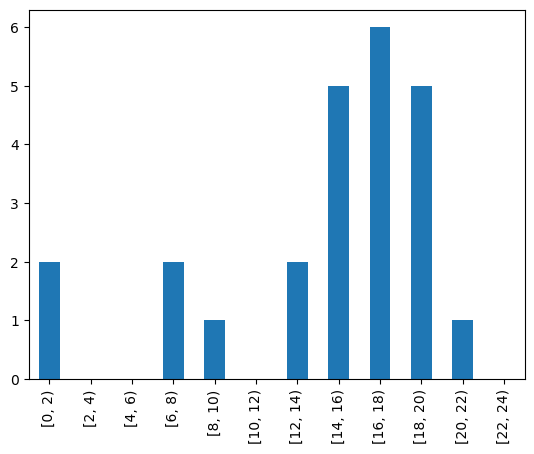

In [10]:
df['eventTime'] = pd.to_datetime(df['eventTime'])

# Фильтруем датафрейм, чтобы включить только те строки, где код события равен 'Пользователь зашел в систему'
# и явно создаём копию отфильтрованного датафрейма
start_activity = df[df['eventCode'] == 'Пользователь зашел в систему'].copy()

# Создаём новый столбец для хранения количества минут с полуночи, когда произошло событие
start_activity['minutes_since_midnight'] = start_activity['eventTime'].dt.hour * 60 + start_activity['eventTime'].dt.minute

# Создаём бины на каждые 2 часа (120 минут)
bins = range(0, 24 * 60 + 1, 120)

# Используем функцию отсечения для бининга данных и подсчета количества событий в каждом бине
start_activity['binned'] = pd.cut(start_activity['minutes_since_midnight'], bins, right=False)
result = start_activity.groupby('binned').size()

# Создаем кастомные лейблы для x-axis
labels = [f'[{h}, {h+2})' for h in range(0, 24, 2)]
result.index = labels

# Визуализируем
result.plot(kind='bar')
plt.show()

Заметьте, как мало ивентов 'Пользователь зашел в систему' в нашем слайсе. Очевидно, это не показатель того, когда человек начал работать с системой. Сделаем то же самое но для ивента 'Пользователь активен'

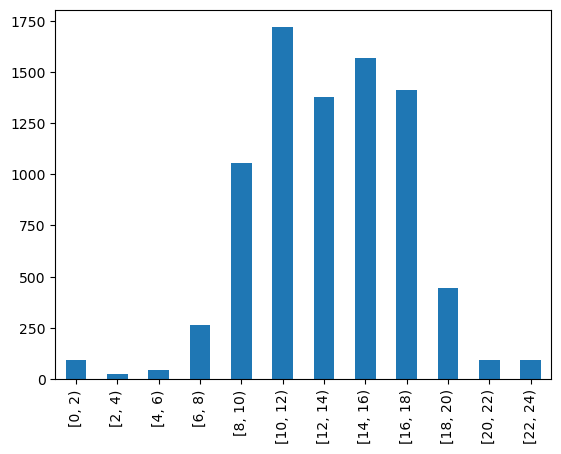

In [11]:
# Фильтруем датафрейм, чтобы включить только те строки, где код события равен 'Пользователь активен'
# и явно создаём копию отфильтрованного датафрейма
start_activity = df[df['eventCode'] == 'Пользователь активен'].copy()

# Создаём новый столбец для хранения количества минут с полуночи, когда произошло событие
start_activity['minutes_since_midnight'] = start_activity['eventTime'].dt.hour * 60 + start_activity['eventTime'].dt.minute

# Создаём бины на каждые 2 часа (120 минут)
bins = range(0, 24 * 60 + 1, 120)

# Используем функцию отсечения для бининга данных и подсчета количества событий в каждом бине
start_activity['binned'] = pd.cut(start_activity['minutes_since_midnight'], bins, right=False)
result = start_activity.groupby('binned').size()

# Создаем кастомные лейблы для x-axis
labels = [f'[{h}, {h+2})' for h in range(0, 24, 2)]
result.index = labels

# Визуализируем
result.plot(kind='bar')
plt.show()

Это уже больше похоже на правду - люди заходят до обеда (10-12), утром, или после (14-16)

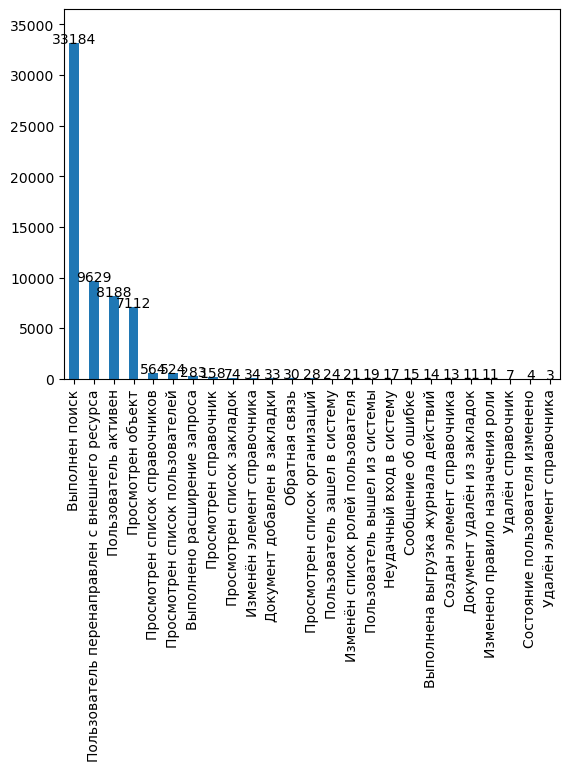

In [12]:
event_counts = df['eventCode'].value_counts()
total_count = event_counts.sum()

event_counts.plot(kind='bar')
plt.ylim(top=event_counts.max() * 1.1) 

for i, count in enumerate(event_counts):
    frequency = count
    plt.text(i, count , f'{frequency}', ha='center')

plt.show()

Визуализируем самый частотные события в слайсе

In [18]:
df['eventDate'] = pd.to_datetime(df['eventTime']).dt.date

# Группируем данные по userId и eventDate, затем подсчитываем количество действий для каждой группы, i.e. юзера
actions_per_day = df.groupby(['userId', 'eventDate'])['eventCode'].count()

# Подсчитаем среднее количество действий в день для каждого пользователя
avg_actions_per_day = actions_per_day.groupby('userId').mean()

In [20]:
avg_actions_per_day.sort_values(ascending=False)

userId
813c5ce3-fa6c-426c-87d6-35c108643c8e    110.823529
7aee4a7f-54c4-4f43-bc95-aa598253822d     94.307692
c5388f24-7ce7-4879-b811-a73003d42ab3     78.000000
7c477a72-8d94-4d08-ac00-ef19e847b0a5     70.000000
ca036cd8-dc22-4377-9fa4-fe073313e464     63.207792
                                           ...    
cf943c19-a2df-447b-9d26-77727d7c555b      1.250000
c7a4348f-e80c-4829-9d95-fff94cd36ef3      1.000000
8489d59e-449e-426d-b806-cc8f90bef813      1.000000
52abde4a-2203-4f0c-b20a-0d99573580ea      1.000000
746873e7-1f3b-42f5-85bb-063dc4dbcb99      1.000000
Name: eventCode, Length: 2261, dtype: float64

Подсчитали среднее количество действий в день для каждого пользователя

In [23]:
# Выведем самых активных пользователей
most_active_users = avg_actions_per_day.sort_values(ascending=False).head()
print('\nПервые 5 самых активных пользователей:')
print(most_active_users)


Первые 5 самых активных пользователей:
userId
813c5ce3-fa6c-426c-87d6-35c108643c8e    110.823529
7aee4a7f-54c4-4f43-bc95-aa598253822d     94.307692
c5388f24-7ce7-4879-b811-a73003d42ab3     78.000000
7c477a72-8d94-4d08-ac00-ef19e847b0a5     70.000000
ca036cd8-dc22-4377-9fa4-fe073313e464     63.207792
Name: eventCode, dtype: float64


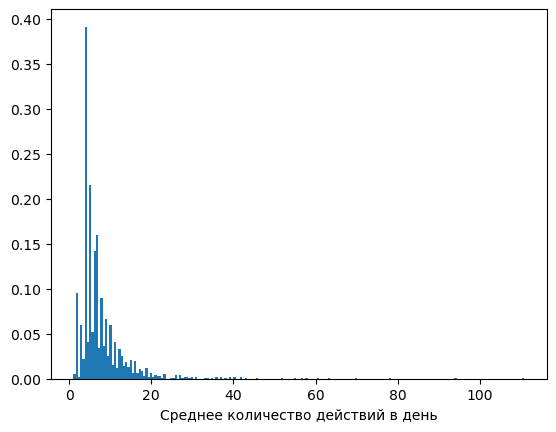

In [18]:
# Создаём гистограмму для визуализации распределения среднего количества действий в день
num_bins = 200
avg_actions_per_day.plot(kind='hist', bins=num_bins, density=True)
plt.xlabel('Cреднее количество действий в день')
plt.ylabel('')
plt.show()

In [25]:
# Сгруппируем данные по userId, затем подсчитаем количество уникальных дат для каждого пользователя
active_days = df.groupby('userId')['eventDate'].nunique()

# Отсортировывваем полученный series по убыванию
active_days_sorted = active_days.sort_values(ascending=False)

print(active_days_sorted)

userId
ca036cd8-dc22-4377-9fa4-fe073313e464    77
ba94f118-6e50-4fb1-98e3-6ad795e19abb    53
3f99c8da-6921-4981-878b-0617e2670f85    52
e18ec9a2-0a4f-4faf-affb-74be0644cae6    36
42f5b7e3-f6e9-48e1-8fbf-f28a76f7e1f9    30
                                        ..
641457b6-3e1e-4e4f-9929-f2177c527870     1
63ea81d0-9b04-47f1-92d7-df2801107ac5     1
63e91727-79d2-4798-9d18-af70c5e457e0     1
63d9242c-284b-4921-8c0c-0593a04a07e6     1
ffe3aa3b-355a-493c-9914-e254e79bdd79     1
Name: eventDate, Length: 2261, dtype: int64


Вывели количество дней каждый пользователь был активен за наблюдаемый промежуток времени

In [45]:
df['eventWeek'] = df['eventTime'].dt.isocalendar().week

# Сгруппируем данные по userId, затем подсчитаем количество уникальных дат для каждого пользователя
active_days = df.groupby('userId')['eventDate'].nunique()

# Сгруппируем данные по id пользователя, 
# затем рассчитаем среднее количество дней между активными днями каждого пользователя.
avg_days_between_activity = df.groupby('userId')['eventDate'].apply(
    lambda x: np.mean(np.diff(np.unique(x))) if len(np.unique(x)) > 1 else np.nan
)

# Сгруппируем данные по userId, затем подсчитаем количество уникальных недель для каждого пользователя
active_weeks = df.groupby('userId')['eventWeek'].nunique()

# Установливаем пороговое значение для минимального количества активных дней
threshold = 10

# Фильтруем пользователей по порогу
most_active_users = active_days[active_days >= threshold]
most_consistent_users = avg_days_between_activity.loc[most_active_users.index].sort_values(ascending=True)

# Создаем новый датафрейм с наиболее активными и постоянными пользователями,i.e. миниальное кол-во дней между рабочими днями
result = pd.DataFrame({
    'activeDays': active_days.loc[most_consistent_users.index],
    'avgDaysBetweenActivity': most_consistent_users,
    'activeWeeks': active_weeks.loc[most_consistent_users.index]
})

In [47]:
result.sort_values(by=['activeDays','avgDaysBetweenActivity', 'activeWeeks'], ascending=False)[:25]

,activeDays,avgDaysBetweenActivity,activeWeeks
userId,,,
ca036cd8-dc22-4377-9fa4-fe073313e464,77,1 days 08:50:31.578947,16
ba94f118-6e50-4fb1-98e3-6ad795e19abb,53,1 days 23:32:18.461538,16
3f99c8da-6921-4981-878b-0617e2670f85,52,2 days 00:28:14.117647,15
e18ec9a2-0a4f-4faf-affb-74be0644cae6,36,2 days 18:30:51.428571,12
df39b07a-af32-4cc5-a241-16ae51798f52,30,3 days 09:06:12.413793,14
42f5b7e3-f6e9-48e1-8fbf-f28a76f7e1f9,30,3 days 07:26:53.793103,12
b729c594-5022-42fd-9c4e-bfd9b127fcd7,30,2 days 14:04:08.275862,11
324a8ff1-2509-440b-a16f-3e5f73050eca,28,3 days 15:06:40,13
199d3eda-79b8-4461-95c8-28f5e09fd1ed,26,3 days 08:38:24,11


Вывели пользователей, которые +- регулярно пользуется системой. Заметьте, что у в нашем временном промежутке как раз 16 недель. Таким образом, если у человека около 16 недель, то был активным почти каждую неделю 

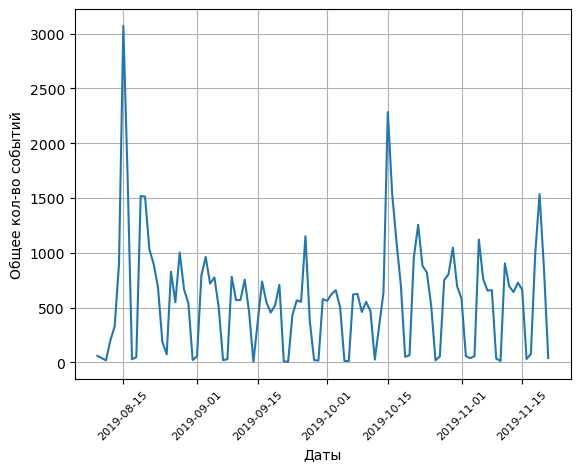

In [50]:
# Группируем данные по eventDate, затем подсчитываем количество действий для каждой даты
actions_per_day = df.groupby('eventDate')['eventCode'].count()

# Создаём линейную диаграмму, чтобы визуализовать общее количество действий в день
actions_per_day.plot(kind='line')
plt.xlabel('Даты')
plt.ylabel('Общее кол-во событий')

# Подправим легенду диаграммы
plt.xticks(rotation=45, fontsize=8)
plt.grid()
plt.show()

Замечаем повторяющиейся паттерны, которые примерно похожи друг на друга, в сумме получается 15 'волн'

In [51]:
df['eventDayOfWeek'] = pd.to_datetime(df['eventTime']).dt.day_name()

# Группируем данные по eventDayOfWeek, затем вычисляем среднее количество действий для каждого дня недели
avg_actions_per_day_of_week = df.groupby('eventDayOfWeek')['eventCode'].count() / df['eventDayOfWeek'].nunique()

# Переставим результирующий series, чтобы дни недели были в порядке
avg_actions_per_day_of_week = avg_actions_per_day_of_week.loc[list(calendar.day_name)]

print(avg_actions_per_day_of_week)

eventDayOfWeek
Monday       1540.714286
Tuesday      1989.000000
Wednesday    1721.714286
Thursday     1869.285714
Friday       1301.571429
Saturday       76.000000
Sunday         73.142857
Name: eventCode, dtype: float64


Теория подтверждается: спад на выходных, скачки во вторник и четверг

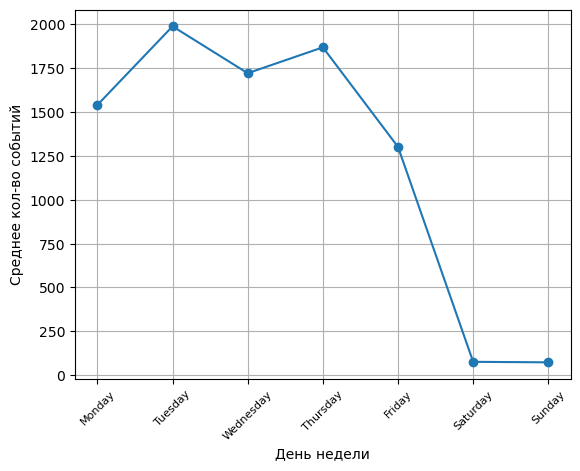

In [53]:
# Создаём линейную диаграмму, чтобы визуализировать среднее количество действий в день недели
avg_actions_per_day_of_week.plot(kind='line', marker='o')
plt.xlabel('День недели')
plt.ylabel('Среднее кол-во событий')
plt.xticks(rotation=45, fontsize=8)
plt.grid()
plt.show()

Если визуально наложить на наши 'волны', то паттерны активности сходятся

In [56]:
# Вытягиваем содержание поисковых запросов
searched = df.loc[df['eventCode'] == 'Выполнен поиск']
searched_l = searched['content'].to_list()

def to_json(x):
  return json.loads(x)

searched_l = list(map(to_json, searched_l))
# Вытягиваем текстовое содержание запросов, если запрос пустой, то заполняем его 'na'
searched_content = [i['docRequest']['query'] if len(i['docRequest']['query']) != 0 else 'na' for i in searched_l]
# Преобразуем список в счёткик частот слов
searched_counter = Counter(searched_content)

In [59]:
# Показываем первые 25 самых частотных запросов
searched_counter.most_common()[:25]

[('na', 14992),
 ('Тестовый поиск по НМД и Сибирской нефти', 125),
 ('нефть', 97),
 ('Тестовый поиск по НМД, Сибирской нефти и СРЗ', 73),
 ('грейд', 62),
 ('КТ-001', 50),
 ('суод', 48),
 ('стратегия 2030', 48),
 ('КТ-040', 48),
 ('горячая линия', 39),
 ('чек лист тс', 38),
 ('шельф', 37),
 ('оформление командировки', 35),
 ('КТ-004', 34),
 ('кт-040', 33),
 ('тест', 33),
 ('Поиск по порталу', 32),
 ('\\\\gazprom-neft.local\\dfs\\Газпром нефть\\Проекты\\ПЭБ, ОТ и ГЗ (файлообмен)\\Перекрестные аудиты\\Перекрестный аудит  ГПН Мессояханефтегаз',
  32),
 ('дюков', 31),
 ('ценности', 31),
 ('единая социальная политика', 30),
 ('обработка', 29),
 ('итск', 29),
 ('КТ-362', 29),
 ('ФЧЗ', 29)]

In [68]:
percen_na = searched_counter['na'] / sum(searched_counter.values())

print(f'Кол-во процентов пустых запросов: {percen_na:.2f}')

Кол-во процентов пустых запросов: 0.45


Заметьте, как много пустых запросов - 45 %! 

In [104]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/6c/Oak-wine-barrel-at-toneleria-nacional-chile.jpg

--2023-07-16 21:59:19--  https://upload.wikimedia.org/wikipedia/commons/6/6c/Oak-wine-barrel-at-toneleria-nacional-chile.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285855 (279K) [image/jpeg]
Saving to: ‘Oak-wine-barrel-at-toneleria-nacional-chile.jpg’

Oak-wine-barrel-at- 100%[===================>] 279.16K  --.-KB/s    in 0.07s   

2023-07-16 21:59:19 (4.01 MB/s) - ‘Oak-wine-barrel-at-toneleria-nacional-chile.jpg’ saved [285855/285855]



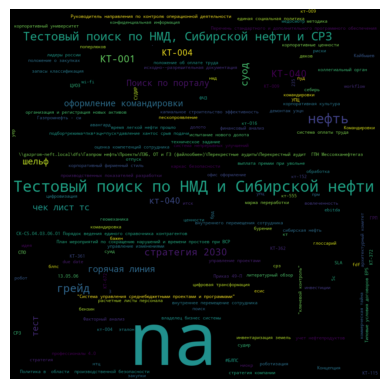

<Figure size 20000x10000 with 0 Axes>

In [183]:
# Саздадим облако слов для визулизации облака слов
wordcloud = WordCloud(max_font_size=200, min_font_size=10, width=1000, height=1000, max_words=150).generate_from_frequencies(searched_counter)

# Визуализируем облако
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(200, 100))
plt.show()

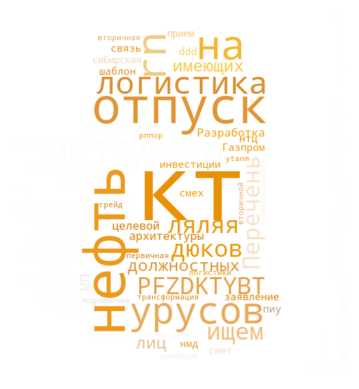

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from io import BytesIO
import requests

text = ' '.join(list(searched_counter.keys())[:60])
# 
# https://upload.wikimedia.org/wikipedia/commons/b/bb/B200.jpg"
response = requests.get("https://upload.wikimedia.org/wikipedia/commons/b/bb/B200.jpg")
mask = np.array(Image.open(BytesIO(response.content)))

image_colors = ImageColorGenerator(mask)

wc = WordCloud(background_color = "white", repeat = False, mask = mask)
wc.generate(text) 

plt.axis("off")
plt.imshow(wc.recolor(color_func=image_colors), interpolation = "bilinear")

plt.show()

Облако слов в виде бочки!

# Задание 2 (Анализ)

# Попробуем провести группировку

In [184]:
device = torch.device('cuda')

# модель выбора - rubert 
model_name = 'DeepPavlov/rubert-base-cased'

# Подгружаем модель и токенайзер
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Переносим на ГПУ
model.to(device)


# Получаем эмбединги для каждого запроса
embeddings = []
for word in tqdm(searched_counter.keys()):
    # Токенизируем слово и преобразуем его в тензор
    input_ids = tokenizer.encode(word, return_tensors='pt')

    # Переносим тензор на ГПУ
    input_ids = input_ids.to(device)

    # Прогоняем через берт
    with torch.no_grad():
        output = model(input_ids)

    # Вместо эбединга для каждого токена, которые мы потом будем усреднять,
    # мы берём CLS токен каждого запрос, используя next sentece prediction фичу тренировки берта
    cls_embedding = output[0][:, 0, :].squeeze().cpu().numpy()
    embeddings.append(cls_embedding)

# переводим эмбединги в numpy
embeddings = np.array(embeddings)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 7783/7783 [01:16<00:00, 101.49it/s]


На ГПУ извлечение эмбедингов занимает около минуты

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_28/2203186496.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', len(np.unique(labels)))
/tmp/ipykernel_28/2203186496.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=cmap(labels[i]))


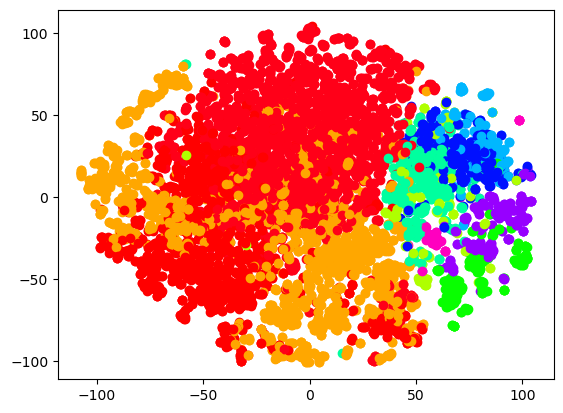

In [187]:
# Создаем модель KMeans с нужным количеством кластеров
kmeans = KMeans(n_clusters=10, random_state=41)

# Фитим модель на эмбедингах
kmeans.fit(embeddings)

# Получаем лейблы кластера для каждой точки данных
labels = kmeans.labels_

# Если хотите ускорить процесс, закомментите линии ниже, 
# но тогда не увидите как кластеры вышли :(

# Понижаем размерность до 2d, используя t-SNE
tsne = TSNE(n_components=2, perplexity=min(30, len(counter) - 1))
embeddings_2d = tsne.fit_transform(embeddings)

# Красим кластеры
cmap = plt.cm.get_cmap('hsv', len(np.unique(labels)))

# Рисуем кластеры на графике, может занять пару минут, к сожалению
for i, (word, count) in enumerate(searched_counter.items()):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=cmap(labels[i]))

plt.show()

In [189]:
# Найдем и напечатаем 5 самых часто встречающихся слов в каждом кластере
words = list(searched_counter.keys())
for label in np.unique(labels):
    cluster_words = [words[i] for i in range(len(words)) if labels[i] == label]
    top_words = sorted(cluster_words, key=lambda x: searched_counter[x], reverse=True)[:20]
    print(f'Cluster {label}: {top_words}')

Cluster 0: ['na', 'грейд', 'суод', 'чек лист тс', 'шельф', 'кт-040', 'тест', 'дюков', 'итск', 'срз', 'кт-016', 'методика', 'пуд', 'кт', '235', 'кт-009', 'кт-004', 'отпуск', 'ниокр', 'блпс']
Cluster 1: ['КТ-001', 'КТ-040', 'КТ-004', 'Поиск по порталу', 'КТ-362', 'ФЧЗ', 'КТ-372', 'ГРП', 'СРЗ', 'ЦУОЗ', 'СУДИР', '3', 'КТ-115', 'SLA', 'Командировки', 'долото', 'поперлюков', 'КТ-009', 'fdf', 'due date']
Cluster 2: ['подбор+режима+пкв+эцн+пуск+давление хантос срыв подачи', '*портал*инициатив*', 'переход на УПЦ 4.0', 'справка обоснование необходимости закючения соглашения', 'коновалов алексей олегович', 'vtnjlbrf', 'система льгот пао газпром нефть', 'микроб', 'http://srz.gazprom-neft.local/communities/HSE/med/Lists/Clinik', 'грейды пао газпром нефть', 'справка обоснование изменение условий договора', 'кт-555 матрица лимитов финансовых полномочий', "СК 203 ' or '' select * from ", 'конкурс внутренних тренеров', 'инфра-итск-спб ИНРФА-ИТСК-Почта-Корп', 'что является  коммрценской тайной в ПАО  ГП

Таким образом у нас получилось 'провести группировку запросов, выделить похожие или однотипные запросы'. Кластеры получили своё описание здесь в виде самых частотных запросов для того или иного кластера, отталкиваясь от нашего счётчика.
Мы можем видеть, что на сиде 41 мы получаем довольно сильные 10 кластеров, где четко формируется отчётливые группы.

Так, кластер 9 - это тематика HR

Кластер 7, 3 и 1 - какие-то специфичные кодовые названия проектов

Давайте попробуем с другим сидом - сид 40

In [191]:
# Создаем модель KMeans с нужным количеством кластеров
kmeans = KMeans(n_clusters=10, random_state=40)

# Фитим модель на эмбедингах
kmeans.fit(embeddings)

# Получаем лейблы кластера для каждой точки данных
labels = kmeans.labels_

# Найдем и напечатаем 5 самых часто встречающихся слов в каждом кластере
words = list(searched_counter.keys())
for label in np.unique(labels):
    cluster_words = [words[i] for i in range(len(words)) if labels[i] == label]
    top_words = sorted(cluster_words, key=lambda x: searched_counter[x], reverse=True)[:20]
    print(f'Cluster {label}: {top_words}')


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: ['na', 'грейд', 'суод', 'чек лист тс', 'шельф', 'кт-040', 'тест', 'дюков', 'итск', 'срз', 'кт-016', 'методика', 'пуд', 'кт', '235', 'кт-009', 'кт-004', 'отпуск', 'ниокр', 'блпс']
Cluster 1: ['КТ-001', 'КТ-040', 'КТ-004', 'Поиск по порталу', 'КТ-362', 'ФЧЗ', 'КТ-372', 'ГРП', 'СРЗ', 'ЦУОЗ', 'СУДИР', '3', 'КТ-115', 'SLA', 'Командировки', 'поперлюков', 'КТ-009', 'fdf', 'due date', 'Приказ 49-П']
Cluster 2: ['система непрерывных улучшений', 'капиальное строительство эффективность', 'подбор+режима+пкв+эцн+пуск+давление хантос срыв подачи', '#БЛПС', 'дерево КПЭ', 'Филимонова Вероника', '*портал*инициатив*', 'реализации невостребованного и неликвидного ', 'инструкция по загрузке извлечённых уроках в СРЗ', 'григорьева гульнара борисовна', 'Григорьева ', 'ш-16.08-11', 'проект 1197 ДУЭ', 'список ЦФО', '9-Р от 13.02.2017', 'система распространения знаний', 'ИСУП 2.0', 'сугаипов', 'схема процесса проектного управления', 'каталог 085 стандартное прикладное программное обеспечение']
Cluste

Ситуация похожия, но теперь мы видим четкий кластер 5 с адресами корпоративной почты:

In [192]:
[words[i] for i in range(len(words)) if labels[i] == 5]

['Iponova.NV@gazprom-neft.ru',
 'CDU@gazprom-neft.ru',
 'QlikView@gpn.ru',
 'a.gubyanova@ekaterinburg.tr-gazprom.ru',
 'orb_umto@gazprom-neft.ru',
 'Davydov.ALV@gazprom-neft.ru',
 'RPA@gazprom-neft.ru ',
 'smo-ditat@gazprom-neft.ru',
 'Vysotskiy.MN@gazprom-neft.ru',
 'UTRVC@gazprom-neft.ru',
 'cps@gazprom-neft.ru',
 'USP@gazprom-neft.ru',
 'zakupki.gazprom-neft.ru',
 'Sukhov.AG@gazprom-neft.ru']

# Выделим именованные сущности

In [203]:
navec = Navec.load('/kaggle/working/navec_news_v1_1B_250K_300d_100q.tar')
ner = NER.load('/kaggle/working/slovnet_ner_news_v1.tar')
ner.navec(navec)

NER(
    infer=NERInfer(
        model=NER(
            emb=WordShapeEmbedding(
                word=NavecEmbedding(
                    id='news_v1_1B_250K_300d_100q',
                    indexes=Weight(
                        shape=[250002,
                         100],
                        dtype='uint8',
                        array=array([[176, 222, 248, ..., 244, 183, 191],
                               [215, 200, 168, ..., 120, 217,  21],
                               [ 83, 174,  54, ..., 106,  88, 251],
                               ...,
                               [133, 125, 123, ..., 124,  94,  24],
                               [183,  49, 180, ..., 151, 167,  68],
                               [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
                    ),
                    codes=Weight(
                        shape=[100,
                         256,
                         3],
                        dtype='float32',
                        array

Воспользуемся инструментами Наташи

In [204]:
def get_nes(text, pers_list, org_list, loc_list):
    markup = ner(text)
    text_in = markup.text
    spans = markup.spans
    for i in spans:
        if i.type == 'PER':
            pers_list.append(text_in[i.start: i.stop])
        elif i.type == 'LOC':
            loc_list.append(text_in[i.start: i.stop])
        elif i.type == 'ORG':
            org_list.append(text_in[i.start: i.stop])

Создаём функцию для извлечения сущностей с помощью Наташи

In [205]:
# Получаем список уникальных запросов
words = list(searched_counter.keys())

In [206]:
# Вытягиваем итеративно сущности
pers = list() # Люди
loc = list() # Места
org = list() # Организации
for i in tqdm(words):
    try:
        get_nes(i, pers, org, loc)
    except:
        continue

100%|██████████| 7783/7783 [00:15<00:00, 517.43it/s]


In [211]:
print(f'Всего персоналий найдено: {len(pers)}')

Всего персоналий найдено: 324


In [212]:
pers[:100]

['Кт-040',
 'Кт-040',
 'Карнаухов',
 'Шаблон',
 'Винокуров Сергей Анатольевич',
 'Шкиров',
 'Югов',
 'Марчук Владислав Ярославович',
 'Безверхий',
 'Кононеров Константин Викторович',
 'Крылов',
 'Крылов Константин',
 'Крылова',
 'Алина',
 'Крылов Денис',
 'Рустамов Игорь',
 'Ск-03.02.02',
 'Нефтеконтроль',
 'Гаврилов Николай',
 'Кузеванова Галина Евгеньевна',
 'Ганина',
 'Вакуленко',
 'Туманский',
 'Ск-01',
 'Шилехина Алёна Сергеевна',
 'Великанв',
 'Великанов',
 'Суприд',
 'Хеджирован',
 'Евгения Игольникова',
 'Пеева Надежда',
 'Зарубин Андрей',
 'Исламов Радик  Анваорвич',
 'Исламов Радик  Анварович',
 'Пономарёв Константин',
 'Полеозой',
 'Бажен',
 'Командирова',
 'Хаертдинова Дина',
 'Змиенко',
 'Попова Валентина',
 'Александрова Мария Андреевна',
 'Шагабутдинов Ильдар Минефаридович',
 'Киляков',
 'Мухамадеев Альберт',
 'Мильков',
 'Александр',
 'Легко',
 'Легко',
 'Будылин Алексей Викторович',
 'Яковлев',
 'Карасев Андрей Михайлович',
 'Вова',
 'Мелёхин Д.Н.',
 'Шадымухамедов',
 

In [213]:
print(f'Всего локаций найдено: {len(loc)}')

Всего локаций найдено: 54


In [214]:
loc

['Газ',
 'Сибирская',
 'ЦФО',
 'РОССИИ',
 'РОССИИ',
 'РОССИИ',
 'РОССИИ',
 'Геология',
 'ХМАО',
 'ХМАО',
 'ПНР',
 'ПНР',
 'Легко',
 'Новосибирская обл',
 'Новосибирск',
 'РФ',
 'Командировки',
 'ТС',
 'Газпромнефть-Снабжение',
 'РФ',
 'Никипелов',
 'Галвный',
 'Газпромнефть-Развитие',
 'Косова',
 'ЦТ',
 'ЦФО',
 'Сибирской',
 'Сибирской',
 'Шельф',
 'Курдский автономный',
 'Болгарского сектора',
 'Чёрного моря',
 'ГПН',
 'Почтамтской',
 'Юпитер',
 'Москва',
 'Солнечная энергетика',
 'Таджикистан',
 'Таджикистан',
 'Таджикистан',
 'Газпромнефть шельф',
 'ГПН-Ямал',
 'ГПН-Ямал',
 'Якорная Станция',
 'Рабочей зоне',
 'Тюмень',
 'Гладкое',
 'ПОС',
 'РФ',
 'Бажен',
 'Гпн-Гео енисей',
 'Марса',
 'Вернигорова',
 'Бурение']

In [215]:
print(f'Всего организаций найдено: {len(org)}')

Всего организаций найдено: 1294


In [216]:
org[:100]

['Газпром',
 'ИС «СПО»',
 'КТ-585',
 'КТ-587',
 'КТ-586',
 'КТ-588',
 'SAP HR',
 'НМД',
 'Ш-01.07.05-20',
 'Ш-01.07.05-24',
 'Ш-01.07.05-147',
 'Ш-01.07.05-07',
 'Ш-01.07.05-07',
 'Сибирской нефти',
 'СК',
 'Gj;fh',
 'СК-02.14.07.03',
 'ПБ',
 'КТ-266',
 'СК',
 'СК',
 'СК',
 'КХД',
 'ИТСК',
 'СК-13.02.01',
 'КТ-372',
 'Ш-01.02.10-07',
 'СК УП',
 'СК',
 'Управления проектами',
 'М-12.02.06-07',
 'М-12.02.06-07',
 'М-12.02.06',
 'ДМС',
 'SAP',
 'КТ-004',
 'НК-346',
 'КТ-004 Термины',
 'ЕСК',
 'ДИТАТ',
 'УИТ КФ',
 'Дирекция по цифровой трансформации',
 'УОЗ',
 'Управление охраны здоровья',
 'КПРА',
 'ЦТ',
 'КТ-03',
 'УСТАВ',
 'СНУ',
 'КТ-361',
 'ТС',
 'ТС',
 'Технический совет',
 'ППР',
 'СУОД',
 'ПСИ',
 'ПСИ ОПЭ',
 'ЛЮТИН',
 'Shell International Trading',
 'УЕР',
 'Ш-01.07.04.01-12',
 'CORP',
 'ПК-12.02-01',
 'AskLegal',
 'КПРА',
 'ДРП',
 'ДР',
 'Комитет потребителей ИТ-услуг',
 'М-01.07.02-05',
 'КУПН',
 'КТ-040',
 'СК-14.05.08',
 'КТ-394',
 'ОПО',
 'КТ-50',
 'ПАО',
 'Ш-16.02.13-11',
 'М

# Попробуем 'выделить группы запросов для которых свойственно переход в источник '

In [218]:
# Заново подгружаем таблицу
df = pd.read_table(r'/kaggle/input/gazprom-test-task/journals_shot.tsv')

df['eventTime'] = pd.to_datetime(df['eventTime'])

# Сортируем по времени и пользователю
df = df.sort_values(by=['userId', 'eventTime'])

# Создаём новый столбец для хранения предыдущего события для каждой строки
df['prevEvent'] = df.groupby('userId')['eventCode'].shift(1)

# Создаём новый столбец для хранения содержимого предыдущего события для каждой строки
df['prevContent'] = df.groupby('userId')['content'].shift(1)

# Отфильтруем строки, в которых текущее событие — 
# 'ObjectViewedJournalEvent', а предыдущее — 'SearchExecutedJournalEvent'
df = df[(df['eventCode'] == 'ObjectViewedJournalEvent') & (df['prevEvent'] == 'SearchExecutedJournalEvent')]

# Извлекаем запрос и objectType из столбца содержимого
df['query'] = df['prevContent'].apply(lambda x: json.loads(x)['docRequest']['query'])
df['objectType'] = df['content'].apply(lambda x: json.loads(x)['content']['objectType'])

In [220]:
# Результаты манипуляций по каждому пользователю: то как у каждого отдельного пользователя
# происходил переход из запроса в событие ObjectViewedJournalEvent
df[['userId', 'query', 'objectType']]

,userId,query,objectType
48869,000f2df0-6be7-40f5-b945-d67112c2f306,каталог сайтов,originalDocument
48888,000f2df0-6be7-40f5-b945-d67112c2f306,цифровой помощник,originalDocument
48893,000f2df0-6be7-40f5-b945-d67112c2f306,сап личчный кабинет,originalDocument
48910,000f2df0-6be7-40f5-b945-d67112c2f306,инновации,originalDocument
48923,000f2df0-6be7-40f5-b945-d67112c2f306,,document
...,...,...,...
14083,ffa62622-8f2f-4dbb-bad0-e14d1b7e2370,,originalDocument
43303,ffe3aa3b-355a-493c-9914-e254e79bdd79,М-02.14.01-01,originalDocument
43305,ffe3aa3b-355a-493c-9914-e254e79bdd79,,document
43315,ffe3aa3b-355a-493c-9914-e254e79bdd79,,document


In [221]:
df_corr = df[['userId', 'query', 'objectType']]

In [222]:
# Сгруппируем данные по 'query' и 'objectType' и подсчитаем количество каждой комбинации
query_object_counts = df.groupby(['query', 'objectType']).size().reset_index(name='count')

In [223]:
query_object_counts

,query,objectType,count
0,,document,1388
1,,originalDocument,665
2,,profile,59
3,,originalDocument,2
4,,originalDocument,1
...,...,...,...
2106,№П-99 от 17.10.2016,originalDocument,1
2107,М-01.07.04-02,originalDocument,1
2108,М-01.07.04-03,originalDocument,1
2109,М-01.07.04-06,originalDocument,1


Теперь мы видим, что после выполнения пустого 'поиска с большой вероятностью случается событие ObjectViewedJournalEvent'

In [226]:
query_object_counts.sort_values(by='count', ascending=False)[:50]

,query,objectType,count
0,,document,1388
1,,originalDocument,665
2,,profile,59
1066,грейд,originalDocument,25
357,КТ-040,originalDocument,15
1881,стратегия 2030,originalDocument,14
1351,кт-040,originalDocument,13
1362,кт-152,originalDocument,12
347,КТ-001,originalDocument,11
390,КТ-362,originalDocument,10


Вывели первые 50 для наглядности

На данным момент кажется странным, что так много пустых запросов, которые при этом куда-то ведут, что дает наводит на мысль, что я получил 'redacted' слайс данных. Тем не менее, можно заметить, что есть устойчивые комбинации, после которых происходит искомое событие

# Попробуем поработать с опечатками

# Метод 1 (используя готовое решение)

In [227]:
def find_misspelled_words(text_list, language='ru'):
    spell = SpellChecker(language=language)
    misspelled_words = []
    for text in text_list:
        words = text.split()
        misspelled = spell.unknown(words)
        misspelled_words.extend(misspelled)
    return misspelled_words

In [230]:
all_words_for_check = list(searched_counter.keys())

In [231]:
method_1_missp = find_misspelled_words(all_words_for_check)

In [236]:
Counter(method_1_missp).most_common()[-100:]

[('гукасьян', 1),
 ('олим', 1),
 ('power', 1),
 ('ggn', 1),
 ('ппт', 1),
 ('bef.gazprom-neft.local', 1),
 ('инфографики', 1),
 ('роликов', 1),
 ('исходные', 1),
 ('патрушев', 1),
 ('диалоги', 1),
 ('развитии', 1),
 ('сагалаков', 1),
 ('сертификация', 1),
 ('ш-01.06.03.02-01', 1),
 ('кт-100', 1),
 ('кюрасао', 1),
 ('м-01.02.01.02.01.-01', 1),
 ('м-13.09-03', 1),
 ('свд', 1),
 ('м-06.01.02.01.02.01-01', 1),
 ('тестовых', 1),
 ('кашапов', 1),
 ('#гпн-снабжение', 1),
 ('днные', 1),
 ('#гпн-нтц', 1),
 ('этапам', 1),
 ('стоимостных', 1),
 ('вероятностный', 1),
 ('иппб', 1),
 ('определения', 1),
 ('результат-2018', 1),
 ('медпункт', 1),
 ('инфраструктуру', 1),
 ('технологий.', 1),
 ('15.03.06', 1),
 ('апробации', 1),
 ('вавыа', 1),
 ('лидерство', 1),
 ('активы', 1),
 ('голец', 1),
 ('openshift', 1),
 ('ограниечение', 1),
 ('закупкам', 1),
 ('ск-03.07.03', 1),
 ('плоттер', 1),
 ('мб/с', 1),
 ('"мб/с"', 1),
 ('мегабит', 1),
 ('нефтебург', 1),
 ('мегабайт', 1),
 ('ск-07.01', 1),
 ('бородач', 1),

Как можно заметить данный метод даёт смешанный результат

# Метод 2 (нейросетевой - perplexity)

В данном методе мы попробуем отталкиваться от идеи, что словам, которые написаны неправильно, модель типа seq2seq, i.e. encoder-decoder, будет давать низкий скор perplexity, i.e. вероятность, что такая последовательность реальна\возможна

In [238]:
device = "cuda"
model = AutoModelForSeq2SeqLM.from_pretrained("ai-forever/ruT5-base").to(device)
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruT5-base")

In [240]:
def get_ppl(input_str: str) -> float:
  encodings = tokenizer(input_str, return_tensors="pt")
  max_length = 512
  stride = 4
  seq_len = encodings.input_ids.size(1)

  nlls = []
  prev_end_loc = 0
  for begin_loc in range(0, seq_len, stride):
      end_loc = min(begin_loc + max_length, seq_len)
      trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
      input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)

          # loss is calculated using CrossEntropyLoss which averages over input tokens.
          # Multiply it with trg_len to get the summation instead of average.
          # We will take average over all the tokens to get the true average
          # in the last step of this example.
          neg_log_likelihood = outputs.loss * trg_len

      nlls.append(neg_log_likelihood)

      prev_end_loc = end_loc
      if end_loc == seq_len:
          break

  ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
  # print(float(ppl))
  # print(input_str)
  return float(ppl)

In [243]:
results_ppl = []

# Извлекаем peplexity для каждого слова
# На ГПУ может занять минуты 3, на ЦПУ не рекомендую рисковать
for string in tqdm(all_words_for_check):
    result = get_ppl(string)
    results_ppl.append((string, result))

df_ppl = pd.DataFrame(results_ppl, columns=['String', 'Result'])
df_ppl = df_ppl.sort_values(by='Result', ascending=False)

100%|██████████| 7783/7783 [03:18<00:00, 39.17it/s]


In [244]:
df_ppl.sort_values(by='Result', ascending=False)[:50]

,String,Result
6514,подать идею,275192000.0
3765,Положении о проведении конкурса «Степпер»,203560048.0
3943,Комплекс Галерная 5,199355744.0
5822,отнесение затрат по видам деятельнсоти,169958544.0
6708,Проект ERP 1C SAP,129235256.0
6658,судно долгий,110539720.0
4860,свойства нефти,108645528.0
4456,испытательный центр центрального региона,75542456.0
5276,культура согласия,73174976.0
614,Хеджирован,71680856.0


In [245]:
df_ppl.sort_values(by='Result', ascending=False)[-50:]

,String,Result
5937,управление эффективностью и постоянное соверше...,17.476456
1830,Шушаков Александр Анатольевич,17.339996
2836,производственнйы контроль 16.08,17.139648
4402,14.05.05,17.057823
4371,13.05.05,16.988441
5197,приготовление,16.442329
6818,sap sf,16.213505
157,аудит,15.215749
2425,печников дмитрий евгеньевич,15.196716
5055,архипов сибирская нефть,15.156099


Сложно сказать, что данный метод работает для определение правильности слова\фразы, по отфитрованным скорам это точно проблематично заключить. Для проверки теории нужно собрать датасет типа CoLa и проверить, можно ли вообще надежно определять грамматичность - спойлер, с коллегами из лаборатории NLP в Сколтехе я уже проверял данную теорию на основе корпусов Cola английского, русского, французского, итальянского, и можно сказать с некоторой уверенностью, что используя для этой задачи модель NLLB, нельзя у уверенностью определять грамматичность, используя perplexity.

# Метод 3 (нейросетевой RuCola)

Для данного метода я использую модель бинарной классификации от Сколтеха "s-nlp/ruRoberta-large-RuCoLa-v1", которая была натренирована на специально подготовленном корпусе RuCola.

Больше про RuCola можно узнать на данном репозитарии https://github.com/RussianNLP/RuCoLA

In [247]:
# Подгружаем пайплайн классификатора
classifier = pipeline("text-classification", model = "s-nlp/ruRoberta-large-RuCoLa-v1", device=0)

In [248]:
# Отфильтруем различные кодовые названия проектов и др.
words_for_check = [i for i in all_words_for_check if '-' not in i]
all_words_for_check = list()

# Раздробим длинные запросы на слова
for i in words_for_check:
    if len(i.split()) == 1:
        all_words_for_check.append(i)
    else:
        all_words_for_check.extend(i.split())

In [249]:
results = []

# Прогоняем наши слова через классификатор
for word in tqdm(all_words_for_check):
    classification = classifier(word)[0]
    label = classification['label']
    score = classification['score']
    results.append({'word': word, 'label': label, 'score': score})

df_out = pd.DataFrame(results)

  0%|          | 7/14884 [00:00<04:04, 60.75it/s]/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 14884/14884 [04:19<00:00, 57.34it/s]


In [250]:
df_out.loc[df_out['label'] == 'unacceptable'].sort_values('score', ascending=False)[:50]

,word,label,score
8925,пемии,unacceptable,0.997769
2335,коммрческой,unacceptable,0.997656
14669,днные,unacceptable,0.997576
4065,приеманя,unacceptable,0.997429
13694,происшествий,unacceptable,0.997032
5097,сотрдуника,unacceptable,0.997029
13835,Газпромнефти,unacceptable,0.996687
2328,коммрченской,unacceptable,0.996457
14727,вавыа,unacceptable,0.996423
10085,днных,unacceptable,0.996373


Как видим результат данным методом неплохой

In [196]:
df_out.loc[df_out['label'] == 'acceptable'].sort_values('score', ascending=True)[:50]

,word,label,score
4503,таначев,acceptable,0.500394
5761,пир,acceptable,0.500946
6103,демич,acceptable,0.503272
7853,дорог,acceptable,0.503567
7846,дорог,acceptable,0.503567
7833,дорог,acceptable,0.503567
11635,результат,acceptable,0.503996
1629,результат,acceptable,0.503996
14701,результат,acceptable,0.503996
11459,результат,acceptable,0.503996


Выведем acceptable с низким скором, чтобы проверить не упустили ли мы что-то

In [197]:
df_out.loc[df_out['label'] == 'acceptable'].sort_values('score', ascending=False)[:50]

,word,label,score
14795,#промышленная_безопасность_производственных_об...,acceptable,0.999246
4075,"""Стратегия‑2030""",acceptable,0.998859
4074,Стратегия‑2030,acceptable,0.998857
9196,#Процессное_управление_и_стандартизация,acceptable,0.998822
14659,#внутренние_и_внешние_коммуникации,acceptable,0.998762
9198,#Информационные_технологии_и_автоматизация,acceptable,0.998442
14792,видеоконференцсвязь,acceptable,0.998408
4517,целеполагание,acceptable,0.998206
14661,#бухгалтерский_учет,acceptable,0.998163
14657,#бухгалтерский_учет,acceptable,0.998163


Здесь тоже все в порядке

Мы можем заключить, что в нашем случае модель, натринированная на RuCola, находит опечатки лучше всего